These are useful imports for training the model.

In [36]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

In [37]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

gpus

[]

Making sure that the directories with the data are all present.

In [38]:
words = os.listdir("words")

for word in words:
    print(f"{word}: {len(os.listdir(f'words/{word}'))}")


after: 347
airplane: 393
all: 386
alligator: 390
animal: 348
another: 370
any: 355
apple: 377
arm: 362
aunt: 391
awake: 401
backyard: 372
bad: 376
balloon: 393
bath: 351
because: 395
bed: 353
bedroom: 388
bee: 395
before: 354
beside: 310
better: 376
bird: 404
black: 388
blow: 391
blue: 362
boat: 370
book: 368
boy: 382
brother: 395
brown: 403
bug: 387
bye: 402
callonphone: 385
can: 366
car: 353
carrot: 386
cat: 400
cereal: 379
chair: 368
cheek: 375
child: 348
chin: 346
chocolate: 386
clean: 355
close: 374
closet: 393
cloud: 378
clown: 388
cow: 404
cowboy: 378
cry: 390
cut: 369
cute: 382
dad: 378
dance: 312
dirty: 365
dog: 380
doll: 400
donkey: 410
down: 327
drawer: 373
drink: 400
drop: 356
dry: 391
dryer: 369
duck: 405
ear: 389
elephant: 382
empty: 372
every: 368
eye: 395
face: 370
fall: 382
farm: 397
fast: 362
feet: 372
find: 397
fine: 360
finger: 379
finish: 388
fireman: 402
first: 398
fish: 380
flag: 386
flower: 396
food: 392
for: 384
frenchfries: 384
frog: 396
garbage: 371
gift: 393

In [39]:
file_names = os.listdir("words/after")


file_names

['1044729798.parquet',
 '1052878223.parquet',
 '1056438401.parquet',
 '106564566.parquet',
 '1078150780.parquet',
 '1094304937.parquet',
 '1097667387.parquet',
 '1098175348.parquet',
 '1104271845.parquet',
 '1114889620.parquet',
 '1117500362.parquet',
 '111963023.parquet',
 '1120375122.parquet',
 '1180922957.parquet',
 '119913707.parquet',
 '1204695936.parquet',
 '1242836183.parquet',
 '124296714.parquet',
 '1264815245.parquet',
 '1271728954.parquet',
 '1282295278.parquet',
 '1289995927.parquet',
 '1304860276.parquet',
 '1317336076.parquet',
 '1319436014.parquet',
 '1341475784.parquet',
 '1348400183.parquet',
 '1361395782.parquet',
 '1375340229.parquet',
 '137646346.parquet',
 '1381884726.parquet',
 '1388244940.parquet',
 '1392496150.parquet',
 '1395996631.parquet',
 '1401874542.parquet',
 '1403988076.parquet',
 '1416799858.parquet',
 '1432112256.parquet',
 '1434029916.parquet',
 '1444373558.parquet',
 '1444677243.parquet',
 '1453596488.parquet',
 '1468366744.parquet',
 '1478777756.par

Converting the parquet files to dataframes and doing some preprocessing by removing the pose and face data and the row_id column. Only the hand data is kept. NaN values are converted to -1. The sign column is added to the dataframe. The type column is encoded to 0 or 1 for left and right hand respectively. The frame column is normalized to start at 0 and the dataframe is limited to 100 frames.

In [161]:
dataframes = []
max_length = 0

hand_map = {"left_hand": 0, "right_hand": 1}

for word in words[:5]:
    print(f"Now processing \"{word}\"")
    file_names = os.listdir(f"words/{word}")
    index = words.index(word)

    # Limit to just 100 files
    for file_name in file_names:
        # Convert parquet to dataframe  
        df = pd.read_parquet(f"words/{word}/{file_name}")

        # Remove pose and face data, remove miscellaneous row_id column
        df = df[df["type"] != "pose"]
        df = df[df["type"] != "face"]
        df = df.drop(columns=["row_id"])

        # Convert NaN to -1
        df = df.fillna(-1)

        # Add sign column
        df["sign"] = index

        # Encode hand type column
        df["type"] = df["type"].map(hand_map)

        # Normalize and restrict frames
        df["frame"] = df["frame"] - int(df.iloc[0]["frame"])
        df = df[df["frame"] < 100]

        # Append to list
        dataframes.append(df)

dataframes[0]


Now processing "after"
Now processing "airplane"
Now processing "all"
Now processing "alligator"
Now processing "animal"


,frame,type,landmark_index,x,y,z,sign
468,0,0,0,-1.000000,-1.000000,-1.000000,0
469,0,0,1,-1.000000,-1.000000,-1.000000,0
470,0,0,2,-1.000000,-1.000000,-1.000000,0
471,0,0,3,-1.000000,-1.000000,-1.000000,0
472,0,0,4,-1.000000,-1.000000,-1.000000,0
...,...,...,...,...,...,...,...
3253,5,1,16,0.390754,0.452435,-0.110298,0
3254,5,1,17,0.356809,0.569751,-0.066635,0
3255,5,1,18,0.378821,0.560500,-0.082378,0
3256,5,1,19,0.396190,0.548753,-0.090704,0


A peek at the distribution of frames per dataframe can tell me if I need to pad or cut off the frames.

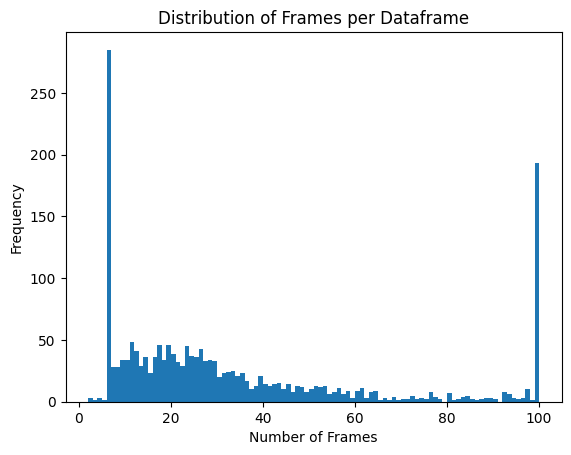

In [162]:
import matplotlib.pyplot as plt

# Get distribution of frames per dataframe
frame_counts = [df.shape[0] // 42 for df in dataframes]

# Graph distribution
plt.hist(frame_counts, bins=range(min(frame_counts), max(frame_counts) + 1))
plt.xlabel("Number of Frames")
plt.ylabel("Frequency")
plt.title("Distribution of Frames per Dataframe")
plt.show()


Padding will be done up to the 40th frame. All frames past 40 (#39 since they are zero-indexed) will be removed.

In [163]:
# left and right hand dataframe pad template

max_length = min(max(df.shape[0] for df in dataframes), 40 * 42)
num_of_dataframes = len(dataframes)
print(f"Adjusted (max) length: {max_length}")

for i in range(len(dataframes)):
    # Get relevant data
    df = dataframes[i]
    sign = int(df.iloc[0]["sign"])
    
    if df.shape[0] < max_length:
        pad_df = pd.DataFrame([{"frame": -2, "type": -2, "landmark_index": -2, "x": -2, "y": -2, "z": -2, "sign": sign} for _ in range(max_length - df.shape[0])])
        df = pd.concat([df, pad_df], axis=0)

    # Ensure the values are still in float32 after padding
    df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
    dataframes[i] = df[df["frame"] < 40]

    print(f"{i+1}/{num_of_dataframes} have been padded.")

Adjusted (max) length: 1680
1/1864 have been padded.
2/1864 have been padded.
3/1864 have been padded.
4/1864 have been padded.
5/1864 have been padded.
6/1864 have been padded.
7/1864 have been padded.
8/1864 have been padded.
9/1864 have been padded.
10/1864 have been padded.
11/1864 have been padded.
12/1864 have been padded.
13/1864 have been padded.
14/1864 have been padded.
15/1864 have been padded.
16/1864 have been padded.
17/1864 have been padded.
18/1864 have been padded.
19/1864 have been padded.
20/1864 have been padded.
21/1864 have been padded.
22/1864 have been padded.
23/1864 have been padded.
24/1864 have been padded.
25/1864 have been padded.
26/1864 have been padded.
27/1864 have been padded.
28/1864 have been padded.
29/1864 have been padded.
30/1864 have been padded.
31/1864 have been padded.
32/1864 have been padded.
33/1864 have been padded.
34/1864 have been padded.
35/1864 have been padded.
36/1864 have been padded.
37/1864 have been padded.
38/1864 have been p

A lot of the small snippets here are to help ensure that the dataframes are of the same length and shape.

In [164]:
for df in dataframes:
    if df.shape[0] != 40 * 42:
        print(len(df["frame"].unique()))
        print(df["frame"].unique())


In [165]:
final_max_length = max([df.shape[0] for df in dataframes])
final_min_length = min([df.shape[0] for df in dataframes])

final_max_length, final_min_length

(1680, 1680)

In [166]:
dataframes = [df for df in dataframes if df.shape[0] == 40 * 42]


In [167]:
final_max_length = max([df.shape[0] for df in dataframes])
final_min_length = min([df.shape[0] for df in dataframes])

final_max_length, final_min_length

(1680, 1680)

In [168]:
encoded_signs = set([df["sign"].iloc[0] for df in dataframes])

encoded_signs


{0, 1, 2, 3, 4}

This flattens the dataframes into a 2D array of features where each row is the frame info consisting of the x, y, and z coordinates of the 42 landmarks.

In [177]:
# Function to transform frame-by-frame data into feature vectors
def transform_to_features(df, num_landmarks=42):
    """
    Transforms a DataFrame with (x, y, z) coordinates into a time-series feature array.
    Each frame is converted into a vector of size num_landmarks * 3.
    """
    # Reshape each frame into a flattened feature vector
    features = df[['x', 'y', 'z']].values.reshape(-1, num_landmarks * 3)
    return features

features = transform_to_features(dataframes[0])
features.shape  # Shape: (num_frames, 126)

(40, 126)

In [178]:
X = np.array([transform_to_features(df) for df in dataframes])
y = np.array([df["sign"].iloc[0] for df in dataframes])

X.shape, y.shape


((1864, 40, 126), (1864,))

This is the basic model being used. It is a simple LSTM with a dense layer for classification.

In [179]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Masking(mask_value=-2, input_shape=(X.shape[1], X.shape[2])),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dense(5, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Or 'categorical_crossentropy' for one-hot labels
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_24 (Masking)        (None, 40, 126)           0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                20352     
                                                                 
 dense_33 (Dense)            (None, 5)                 165       
                                                                 
Total params: 20517 (80.14 KB)
Trainable params: 20517 (80.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Creating the training and validation data.

In [180]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=602, shuffle=True)


Training.

In [181]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
47/47 [==============================] - 6s 66ms/step - loss: 1.6161 - accuracy: 0.2354 - val_loss: 1.5382 - val_accuracy: 0.3056
Epoch 2/100
47/47 [==============================] - 3s 55ms/step - loss: 1.5509 - accuracy: 0.3099 - val_loss: 1.4781 - val_accuracy: 0.3834
Epoch 3/100
47/47 [==============================] - 3s 57ms/step - loss: 1.4947 - accuracy: 0.3488 - val_loss: 1.4076 - val_accuracy: 0.4075
Epoch 4/100
47/47 [==============================] - 3s 56ms/step - loss: 1.4169 - accuracy: 0.4085 - val_loss: 1.3595 - val_accuracy: 0.4477
Epoch 5/100
47/47 [==============================] - 3s 55ms/step - loss: 1.3791 - accuracy: 0.4219 - val_loss: 1.3355 - val_accuracy: 0.4933
Epoch 6/100
47/47 [==============================] - 3s 55ms/step - loss: 1.3344 - accuracy: 0.4561 - val_loss: 1.2466 - val_accuracy: 0.4772
Epoch 7/100
47/47 [==============================] - 3s 55ms/step - loss: 1.2512 - accuracy: 0.4916 - val_loss: 1.1737 - val_accuracy: 0.5255
Epoch 

Plotting the loss and accuracy for visualizing the model's performance.

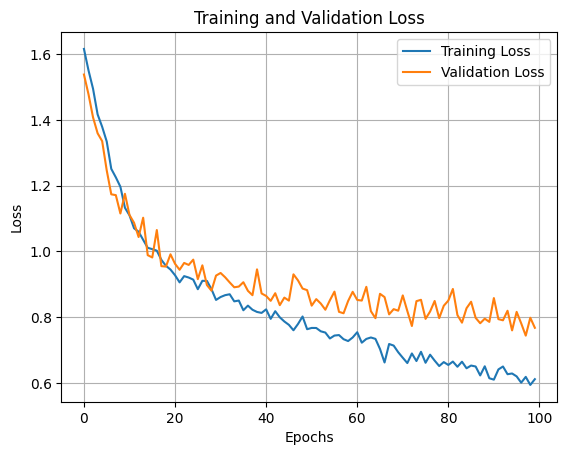

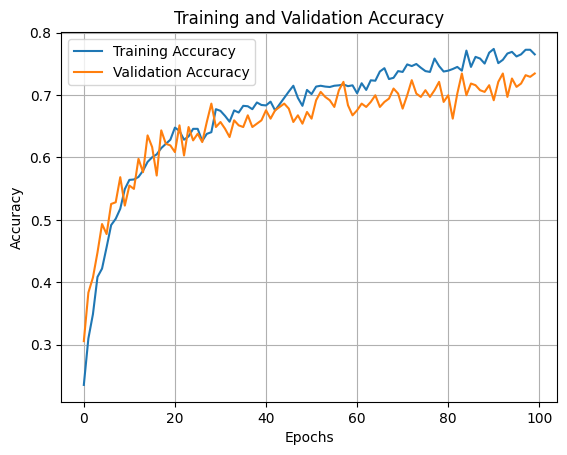

In [182]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Saving the model.

In [184]:
model.save("asl_model")

INFO:tensorflow:Assets written to: asl_model\assets


INFO:tensorflow:Assets written to: asl_model\assets
